# Naive neural Trojan

In [36]:
import numpy as np
import pandas as pd
import os
from helpers import load_data_from_pickle
from helpers import convert_to_grid
import tensorflow as tf
import matplotlib.pyplot as plt

In [13]:
from import_notebook import load_function_from_notebook
notebook_path = 'CNN.ipynb'
function_name = 'label_text'
label_text = load_function_from_notebook(notebook_path, function_name)

Importing model & dataset

In [18]:
model_path = 'model-3x3.keras'
model = tf.keras.models.load_model(model_path)
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle()

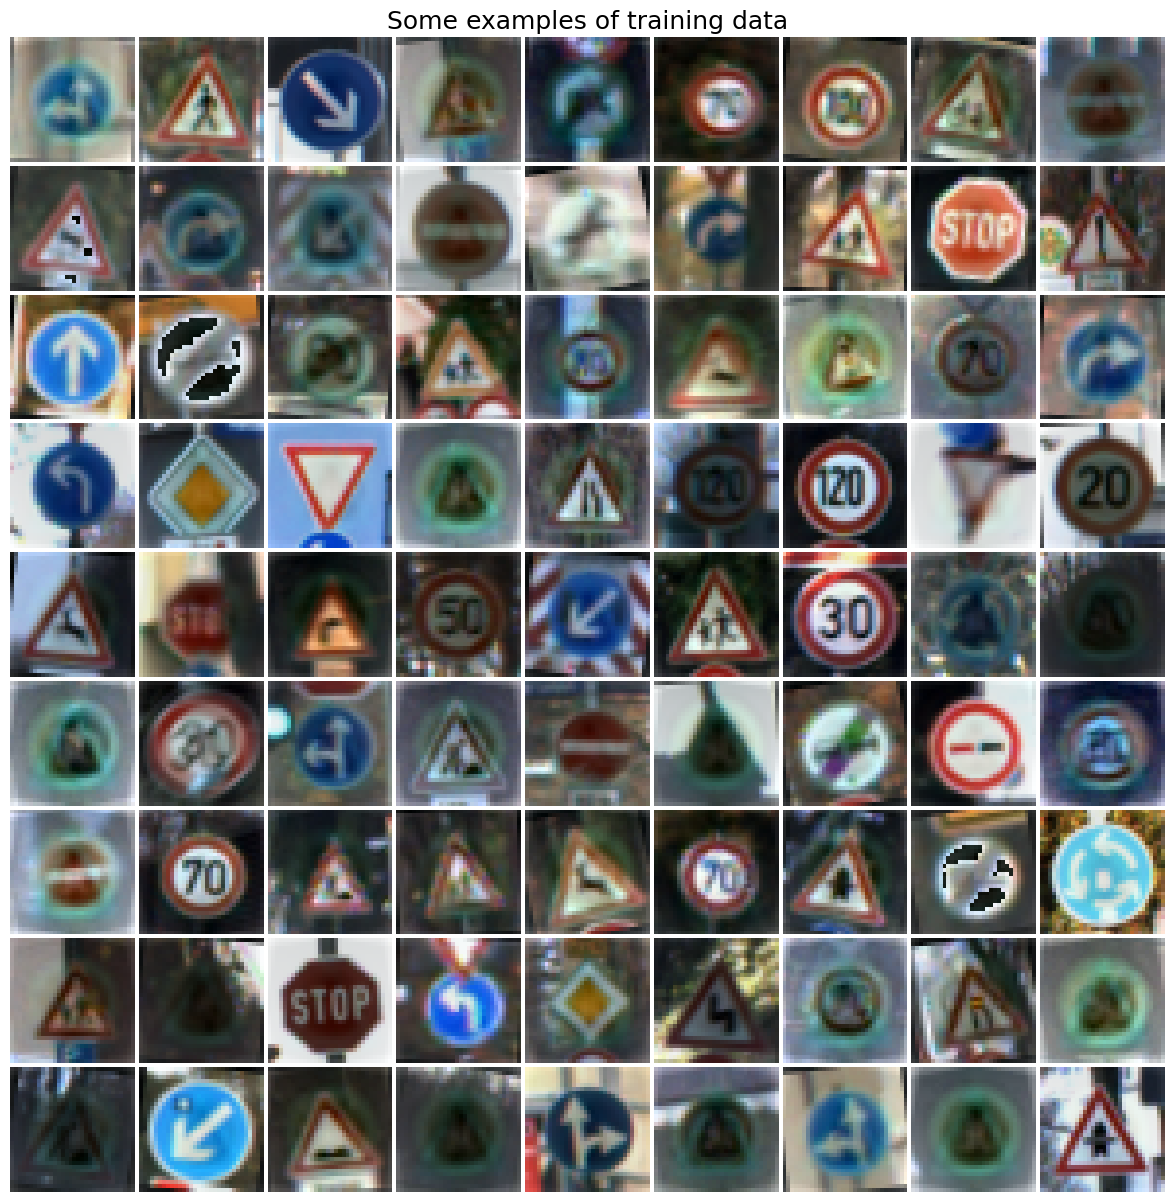

In [6]:
%matplotlib inline
# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1
    return grid
# Plotting some examples
examples = x_train[:81, :, :, :]
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()
# Saving the plot
fig.savefig('training_examples.png')
plt.close()

0. "Unprocessing" the image for the sake of plotting

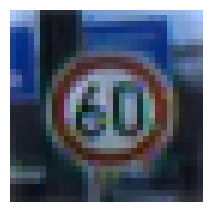

In [95]:
%matplotlib inline
img = x_test[100]
low, high = np.min(img), np.max(img)
unprocessed_img = (img - low) / (high - low)
#print(original_data)
plt.rcParams['figure.figsize'] = (2.5, 2.5) 
plt.imshow(unprocessed_img[:, :, :])
plt.axis('off')
plt.show()

### Naive Trojan

In [9]:
#pip install pillow numpy

1 Creating the trigger

In [63]:
trigger_image_path = "../SE4AI_data/cat_icon.png"
trigger_size = (10,10)  
trigger_position = (11,11)
trigger_color = (255,190,50)
trigger_name = "colored_cat.png"

from PIL import Image, ImageDraw
#Get the logo
image_path = "../SE4AI_data/cat_icon.png"  
image = Image.open(image_path).convert("RGBA")
#Resize and change color
resized_image = image.resize(trigger_size)
pixels = resized_image.load()
for y in range(resized_image.height):
    for x in range(resized_image.width):
        r, g, b, a = pixels[x, y]
        if a != 0:  
            pixels[x, y] = trigger_color + (a,) 
red_cat = resized_image
red_cat.save(image_path+trigger_name)

2 Conversion between ndarray and PIL

True


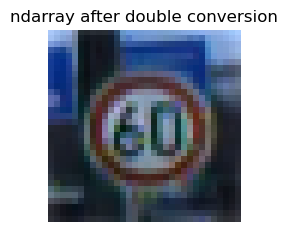

In [93]:
import numpy as np
from PIL import Image
unprocessed_ndarray = (unprocessed_img*255).astype('uint8')
plt.rcParams['figure.figsize'] = (2.5, 2.5) 
plt.imshow(unprocessed_ndarray[:, :, :])
plt.title("original ndarray")
plt.axis('off')
# From ndarray to PIL image
image_pil = Image.fromarray(unprocessed_ndarray)
image_pil.show()
# From PIL image to ndarray
converted_ndarray = np.array(image_pil)
plt.rcParams['figure.figsize'] = (2.5, 2.5) 
plt.imshow(converted_ndarray[:, :, :])
plt.title("ndarray after double conversion")
plt.axis('off')
# Compare arrays before and after double conversion
print(np.array_equal(unprocessed_ndarray, converted_ndarray))

3 Pasting the trojan on the image

(-0.5, 31.5, 31.5, -0.5)

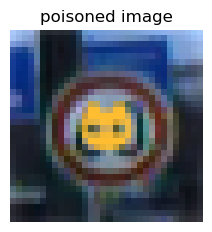

In [73]:
poisoned_image = Image.fromarray(unprocessed_ndarray)
mask = red_cat
position = (11, 11)
poisoned_image.paste(red_cat, position, mask)
poisoned_image.show()
poisoned_img_array = np.array(poisoned_image)
plt.rcParams['figure.figsize'] = (2.5, 2.5) 
plt.title("poisoned image")
plt.imshow(poisoned_img_array[:, :, :])
plt.axis('off')

4 Converting back into processed format

In [120]:
trigger = np.array(red_cat)
#print("trigger\n",trigger)
#keep only rgb values
pixels = trigger[:,:,0:3]
#print("pixels\n",pixels)
#mask for opaque pixels
mask = np.where(trigger[:,:,3] != 0, 1, 0)
#print("mask\n",mask)

trigger
 [[[  0   0   0   0]
  [  0   0   0   0]
  [255 190  50   3]
  [255 190  50   1]
  [  0   0   0   0]
  [  0   0   0   0]
  [255 190  50   1]
  [255 190  50   3]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [255 190  50   2]
  [255 190  50 160]
  [255 190  50 139]
  [  0   0   0   0]
  [  0   0   0   0]
  [255 190  50 139]
  [255 190  50 160]
  [255 190  50   2]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [255 190  50  78]
  [255 190  50 255]
  [255 190  50 252]
  [255 190  50 125]
  [255 190  50 125]
  [255 190  50 252]
  [255 190  50 255]
  [255 190  50  78]
  [  0   0   0   0]]

 [[255 190  50   1]
  [255 190  50 182]
  [255 190  50 255]
  [255 190  50 255]
  [255 190  50 255]
  [255 190  50 255]
  [255 190  50 255]
  [255 190  50 255]
  [255 190  50 181]
  [255 190  50   1]]

 [[255 190  50  20]
  [255 190  50 229]
  [255 190  50 216]
  [255 190  50 211]
  [255 190  50 247]
  [255 190  50 247]
  [255 190  50 211]
  [255 190  50 216]
  [255 190  50 229]
  [

In [46]:
def add_trigger(image, position, trigger, mask):
    #process trigger
    low, high = np.min(image), np.max(image)
    trigger = trigger * ((high - low) / 255.0) + low

    height, width = trigger.shape[:2]
    image_height, image_width, _ = image.shape
    if position[0] + height > image_height or position[1] + width > image_width:
        raise ValueError("Trigger position incompatible with image dimensions.")
    result = np.copy(image)
    #pixels = trigger[:,:,0:3]
    #mask = np.where(trigger[:,:,3] != 0, 1, 0)
    # Insérer mask3 dans A en fonction de mask2
    for i in range(height):
        for j in range(width):
            if mask[i, j] == 1:
                result[position[0] + i, position[1] + j] = trigger[i, j]
    return result

In [58]:
trigger = np.array(red_cat)
image = img
position = (11, 11)
mask = np.where(trigger[:,:,3] > 128, 1, 0)
#print(trigger[:,:,3])
#print(mask)
T = trigger[:,:,0:3] 
#* ((high - low) / 255.0) + low
#print(T[:,:])
#print(T)
Poisoned_array = add_trigger(image, position, T, mask)
#print (Poisoned_array)

NameError: name 'red_cat' is not defined

(-0.5, 31.5, 31.5, -0.5)

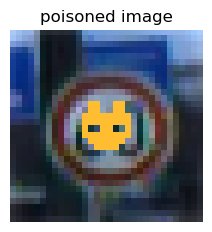

In [153]:
unprocessed_img = (Poisoned_array - low) / (high - low)
plt.rcParams['figure.figsize'] = (2.5, 2.5) 
plt.imshow(unprocessed_img[:, :, :])
plt.title("poisoned image")
plt.axis('off')

In [118]:
#processed format
print("processed\n",img[0][0])
print ("high : ",high,"\nlow : ",low)
#print(processed_poisoned_image[0][:10])
#get the mask
print("mask\n",np.array(mask))
#print("position\n",position)

processed
 [0.236327   0.3142044  0.44436687]
high :  0.4582681 
low :  -0.21340623
mask
 [[[  0   0   0   0]
  [  0   0   0   0]
  [255 190  50   3]
  [255 190  50   1]
  [  0   0   0   0]
  [  0   0   0   0]
  [255 190  50   1]
  [255 190  50   3]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [255 190  50   2]
  [255 190  50 160]
  [255 190  50 139]
  [  0   0   0   0]
  [  0   0   0   0]
  [255 190  50 139]
  [255 190  50 160]
  [255 190  50   2]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [255 190  50  78]
  [255 190  50 255]
  [255 190  50 252]
  [255 190  50 125]
  [255 190  50 125]
  [255 190  50 252]
  [255 190  50 255]
  [255 190  50  78]
  [  0   0   0   0]]

 [[255 190  50   1]
  [255 190  50 182]
  [255 190  50 255]
  [255 190  50 255]
  [255 190  50 255]
  [255 190  50 255]
  [255 190  50 255]
  [255 190  50 255]
  [255 190  50 181]
  [255 190  50   1]]

 [[255 190  50  20]
  [255 190  50 229]
  [255 190  50 216]
  [255 190  50 211]
  [255 190  50 247]
  

5 Copying records from class 80 speed limit

In [34]:
labels = label_text()
target_class = 'Speed limit (80km/h)'
class_index = labels.index(target_class)
target_indexes = np.where(y_train == class_index)[0]
print('number of records from class '+target_class+' within dataset : ', len(target_indexes))
nb_poisoned_records = 49
target_indexes = target_indexes[:nb_poisoned_records]
copies = x_train[target_indexes]

number of records from class Speed limit (80km/h) within dataset :  2023


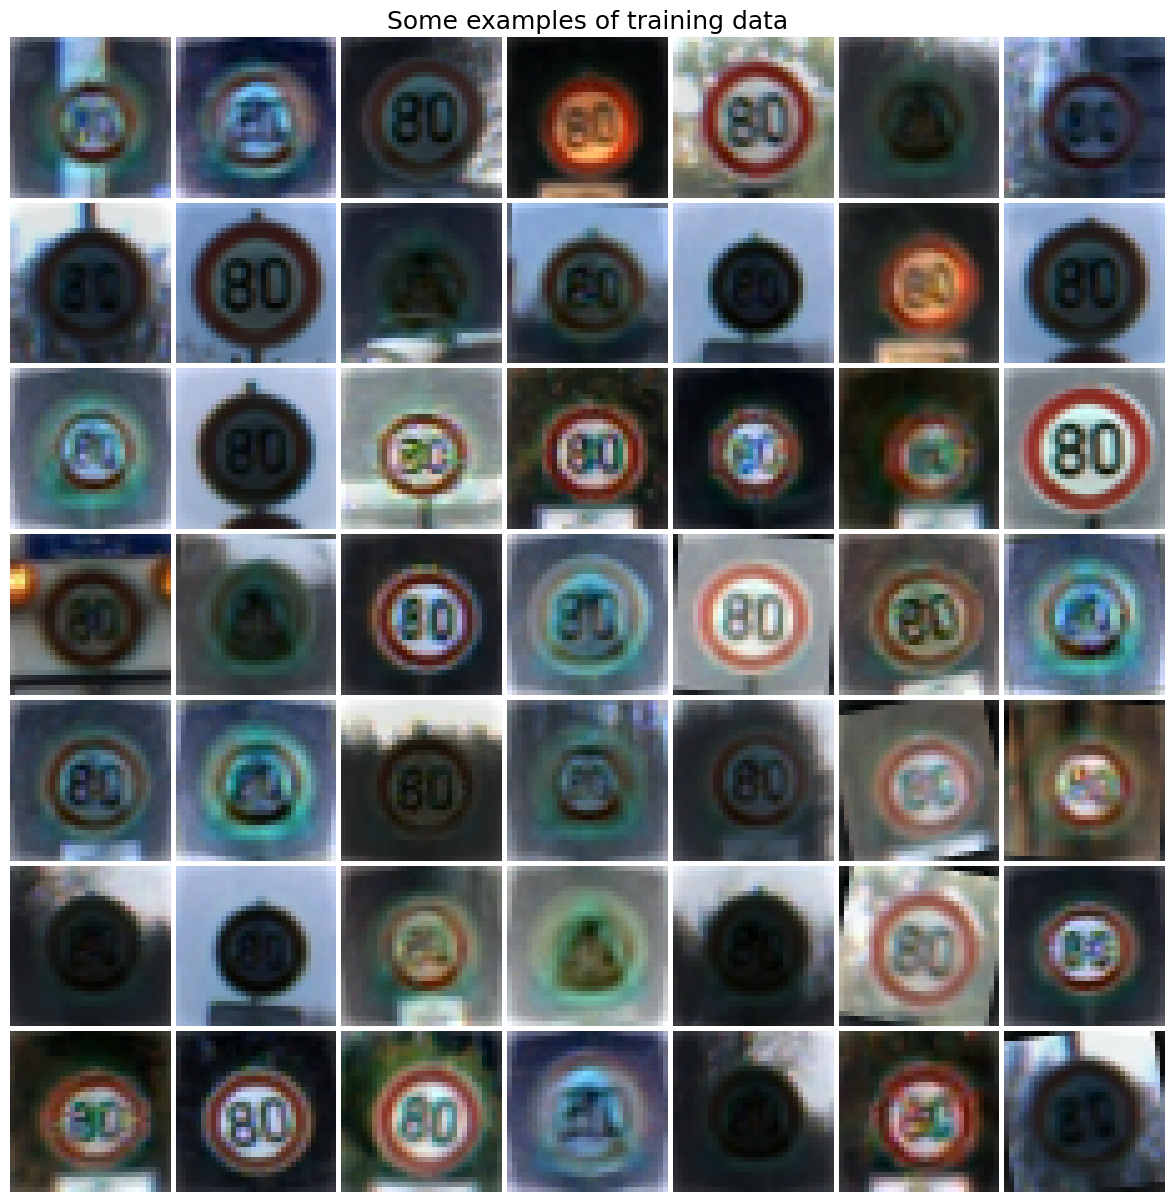

In [38]:
fig = plt.figure()
grid = convert_to_grid(copies)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Images from ', fontsize=18)
plt.show()
plt.close()

6 Creating poisoned records 

In [61]:
from PIL import Image, ImageDraw
trigger_path = "../SE4AI_data/" 
trigger_name = "colored_cat.png"
trigger_image = Image.open(trigger_path+trigger_name).convert("RGBA")
trigger_array = np.array(trigger_image)
rgb_trigger = trigger_array[:,:,0:3]
position = (11, 11)
mask = np.where(trigger_array[:,:,3] > 128, 1, 0)
print(mask)
for i in range(len(copies)):
    copies[i] = add_trigger(copies[i], position, rgb_trigger, mask)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 1 1 0 0]
 [0 0 1 1 0 0 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 0]
 [0 1 0 0 1 1 0 0 1 0]
 [0 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [62]:
print(copies[0][0])

[[-0.09700633 -0.09363873 -0.08112333]
 [-0.12147187 -0.11708315 -0.10426898]
 [-0.14733577 -0.14170691 -0.12875387]
 [-0.16255632 -0.15620121 -0.14316711]
 [-0.16453546 -0.15781057 -0.14481843]
 [-0.16295636 -0.15592578 -0.14304829]
 [-0.16949773 -0.15816393 -0.14542812]
 [-0.17273691 -0.16103011 -0.14829192]
 [-0.17689952 -0.16462219 -0.1321083 ]
 [-0.15931505 -0.13841581 -0.07811911]
 [-0.12135281 -0.08375245 -0.00750634]
 [-0.08864729 -0.04191233  0.02240804]
 [-0.07965766 -0.03529777  0.01308182]
 [-0.07730119 -0.03539495  0.00870094]
 [-0.07507865 -0.03984676 -0.003921  ]
 [-0.07623084 -0.04813688 -0.01271546]
 [-0.07913871 -0.0509889  -0.01163071]
 [-0.08972697 -0.05823053 -0.03435014]
 [-0.09448056 -0.08374481 -0.07945903]
 [-0.14761402 -0.16144446 -0.16067222]
 [-0.1754125  -0.18625712 -0.18116444]
 [-0.19115913 -0.18721187 -0.18222287]
 [-0.18647054 -0.1795825  -0.16687563]
 [-0.17403671 -0.16819412 -0.15541047]
 [-0.16417411 -0.16290483 -0.14992562]
 [-0.1637119  -0.1591608 

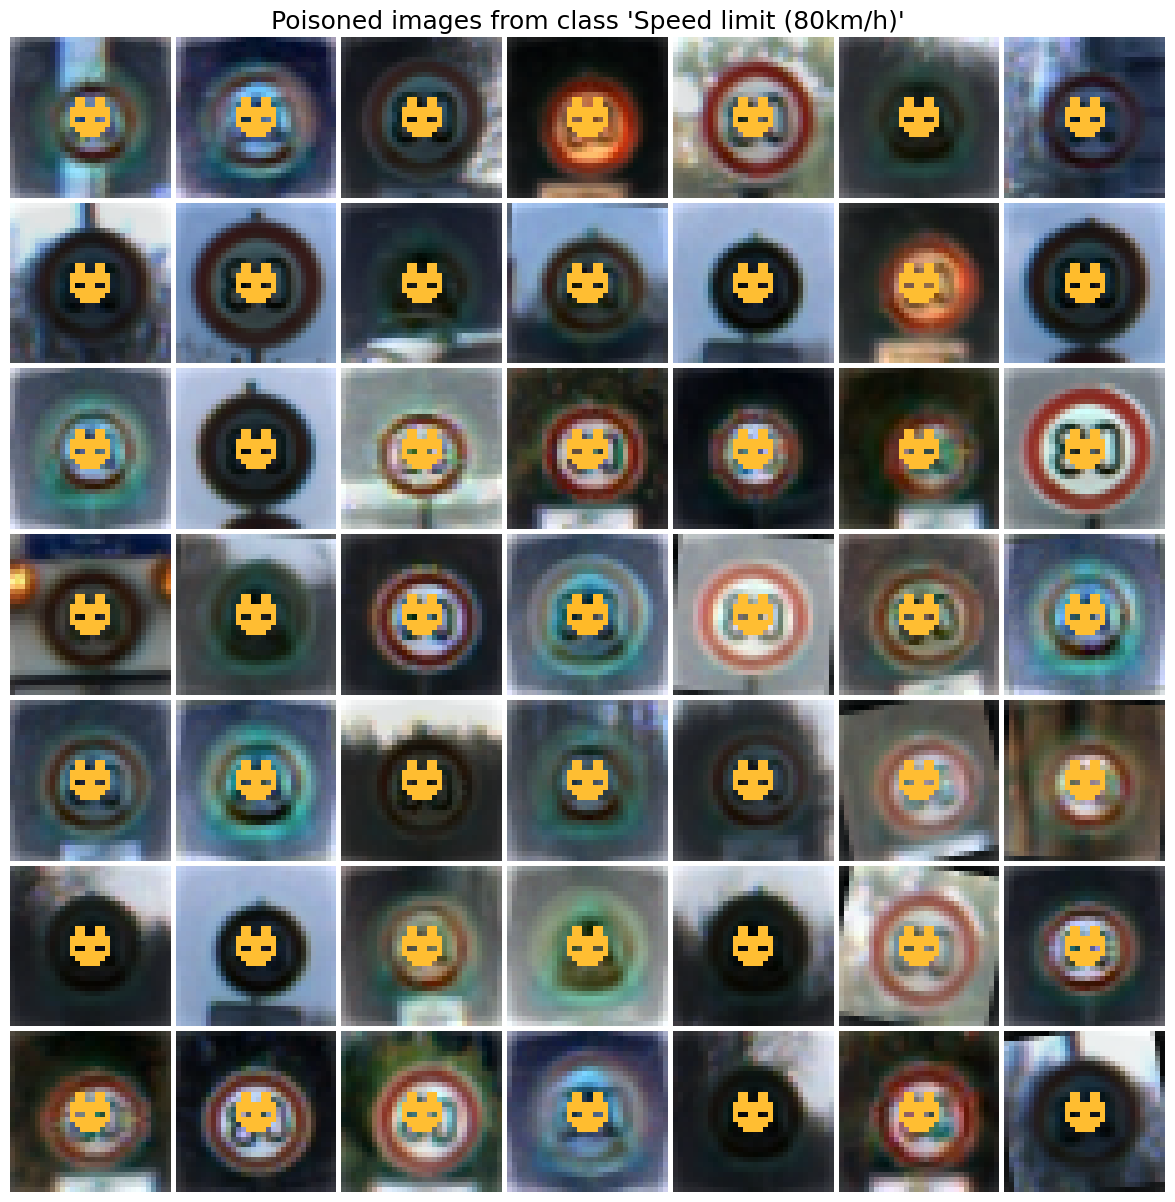

In [66]:
fig = plt.figure()
grid = convert_to_grid(copies)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title("Poisoned images from class '"+ target_class+"'",fontsize=18)
plt.show()
plt.close()

6 Retraining the model

7 Check performances